# Predict Bike Sharing Demand with AutoGluon - Ensiyeh Raoufi

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a complete version of the Kaggle bike sharing demand project.


## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.

2. Scroll down to API and click Create New API Token.

3. Open up `kaggle.json` and use the username and key.


## Step 2: Download the Kaggle dataset using the kaggle python library

### Install packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd './drive/My Drive/aws-kaggle-bike-sharing'

/content/drive/My Drive/aws-kaggle-bike-sharing


In [ ]:
!pwd

/content/drive/My Drive/aws-kaggle-bike-sharing


In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Setup Kaggle API Key

In [ ]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "FILL_IN_USERNAME"
kaggle_key = "FILL_IN_KEY"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms


In [ ]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

test.csv: Skipping, found more recently modified local copy (use --force to force download)
sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
unzip:  cannot find or open bike-sharing-demand.zip, bike-sharing-demand.zip.zip or bike-sharing-demand.zip.ZIP.


In [ ]:
ls 

bike-Models-date-time-predictClass/
bike-Models-enhanced-time-new-hpo-predictClass/
bike-Models-independent-date-time-predictClass/
bike-Models-light-new-hpo-predictClass/
bike-Models-new-hpo-predictClass/
bike-Models-predictClass/
model_test_score.png
model_train_score.png
sampleSubmission.csv
submission.csv
submission_independent_features.csv
submission_new_features.csv
submission_new_hpo.csv
submission_new_light_hpo.csv
test.csv
train.csv


In [ ]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [ ]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
import pandas as pd
train = pd.read_csv('./train.csv', parse_dates=['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
train.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [ ]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
import numpy as np
train.describe()

,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [ ]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test =  pd.read_csv('./test.csv', parse_dates=['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB


In [ ]:

# Same thing as train and test dataset
submission = pd.read_csv('./sampleSubmission.csv', parse_dates=['datetime'])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [ ]:
#If eval_metric = None, it is automatically chosen based on problem_type. Defaults to ‘root_mean_squared_error’ for regression.
save_path = 'bike-Models-predictClass'
predictor = TabularPredictor('count', problem_type='regression', path=save_path, 
                             learner_kwargs={'ignored_columns':['casual', 'registered']} ).fit(train, time_limit=600, presets='best_quality')

Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "bike-Models-predictClass/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 11
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12564.99 MB
	Train Data (Original)  Memory Usage: 0.78 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqu

[1000]	train_set's rmse: 123.806	valid_set's rmse: 134.369
[2000]	train_set's rmse: 117.412	valid_set's rmse: 133.705


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 123.42	valid_set's rmse: 141.5


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 125.097	valid_set's rmse: 128.797
[2000]	train_set's rmse: 119.003	valid_set's rmse: 127.909
[3000]	train_set's rmse: 114.63	valid_set's rmse: 127.431
[4000]	train_set's rmse: 111.295	valid_set's rmse: 126.943
[5000]	train_set's rmse: 108.576	valid_set's rmse: 126.844
[6000]	train_set's rmse: 106.085	valid_set's rmse: 126.71


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.131	valid_set's rmse: 138.303
[2000]	train_set's rmse: 117.833	valid_set's rmse: 137.535


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.871	valid_set's rmse: 128.052
[2000]	train_set's rmse: 118.547	valid_set's rmse: 127.003
[3000]	train_set's rmse: 114.124	valid_set's rmse: 126.834
[4000]	train_set's rmse: 110.645	valid_set's rmse: 126.694


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.654	valid_set's rmse: 135.095
[2000]	train_set's rmse: 118.764	valid_set's rmse: 133.849
[3000]	train_set's rmse: 114.615	valid_set's rmse: 133.509
[4000]	train_set's rmse: 111.249	valid_set's rmse: 133.472
[5000]	train_set's rmse: 108.455	valid_set's rmse: 133.281


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.01	valid_set's rmse: 139.355
[2000]	train_set's rmse: 117.819	valid_set's rmse: 138.312
[3000]	train_set's rmse: 113.4	valid_set's rmse: 137.886
[4000]	train_set's rmse: 110.032	valid_set's rmse: 137.758


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.47	valid_set's rmse: 135.412


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.18	valid_set's rmse: 137.579
[2000]	train_set's rmse: 117.782	valid_set's rmse: 136.664
[3000]	train_set's rmse: 113.447	valid_set's rmse: 136.246
[4000]	train_set's rmse: 109.982	valid_set's rmse: 136.227


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.641	valid_set's rmse: 132.484


	-134.0883	 = Validation score   (root_mean_squared_error)
	66.06s	 = Training   runtime
	2.89s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 318.15s of the 518.15s of remaining time.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' arg

[1000]	train_set's rmse: 96.0217	valid_set's rmse: 123.249


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 94.7479	valid_set's rmse: 135.635


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 95.3055	valid_set's rmse: 132.087


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 95.1635	valid_set's rmse: 131.521


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	-132.2864	 = Validation score   (root_mean_squared_error)
	13.0s	 = Training   runtime
	0.53s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 299.51s of the 499.51s of remaining time.
	-118.4567	 = Validation score   (root_mean_squared_error)
	8.48s	 = Training   runtime


In [ ]:
#!ls -a 'bike-Models-predictClass'
#!zip -r /content/bike-Models-predictClass.zip /content/

In [ ]:
#from google.colab import files
#files.download("/content/bike-Models-predictClass.zip")

### Review AutoGluon's training run with ranking of models that did the best.

In [ ]:
predictor = TabularPredictor.load('./bike-Models-predictClass')  # how to load previously-trained predictor from file
predictor.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3 -115.140710       8.074546  429.313970                0.000886           0.359521            3       True         17
1        LightGBMXT_BAG_L2 -116.093486       6.983480  337.850787                0.302981          12.184751            2       True         11
2   NeuralNetFastAI_BAG_L2 -116.157457       7.087236  401.130653                0.406737          75.464617            2       True         16
3          CatBoost_BAG_L2 -116.521409       6.727717  361.367364                0.047219          35.701328            2       True         14
4          LightGBM_BAG_L2 -116.819839       6.789403  333.818446                0.108904           8.152410            2       True         12
5     ExtraTreesMSE_BAG_L2 -117.526351       7.255038  333.152672         

{'leaderboard':                      model   score_val  ...  can_infer  fit_order
 0      WeightedEnsemble_L3 -115.140710  ...       True         17
 1        LightGBMXT_BAG_L2 -116.093486  ...       True         11
 2   NeuralNetFastAI_BAG_L2 -116.157457  ...       True         16
 3          CatBoost_BAG_L2 -116.521409  ...       True         14
 4          LightGBM_BAG_L2 -116.819839  ...       True         12
 5     ExtraTreesMSE_BAG_L2 -117.526351  ...       True         15
 6      WeightedEnsemble_L2 -118.441584  ...       True         10
 7   RandomForestMSE_BAG_L1 -118.456660  ...       True          5
 8   RandomForestMSE_BAG_L2 -119.396641  ...       True         13
 9     ExtraTreesMSE_BAG_L1 -128.733445  ...       True          7
 10         LightGBM_BAG_L1 -132.286410  ...       True          4
 11          XGBoost_BAG_L1 -132.308522  ...       True          8
 12         CatBoost_BAG_L1 -132.349692  ...       True          6
 13       LightGBMXT_BAG_L1 -134.088334  ...   

### Create predictions from test dataset

In [ ]:
predictions = predictor.predict(test)
predictions.head()

0     97.780212
1     92.688980
2     92.690201
3    108.982773
4    108.886246
Name: count, dtype: float32

In [ ]:
#predictor.leaderboard(test, silent=True)

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [ ]:
# Describe the `predictions` series to see if there are any negative values
predictions[predictions<0]

Series([], Name: count, dtype: float32)

In [ ]:
# How many negative values do we have?
len(predictions[predictions<0])

0

In [ ]:
# Set them to zero
predictions[predictions<0]=0

### Set predictions to submission dataframe, save, and submit

In [ ]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100% 188k/188k [00:00<00:00, 458kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                             date                 description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

#### Initial score of `1.39407`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b23438990>,
      dtype=object)

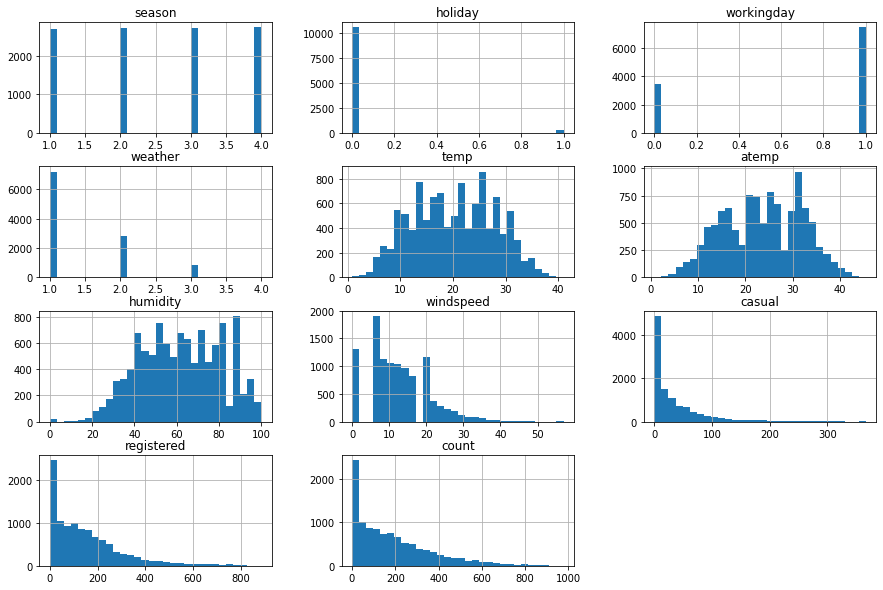

In [ ]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(bins=30, figsize=(15, 10))

In [ ]:
# create a new feature
train['date'] = train['datetime'].dt.date
train['time'] = train['datetime'].dt.time
test['date'] = test['datetime'].dt.date
test['time'] = test['datetime'].dt.time
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,time
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,00:00:00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,01:00:00
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,02:00:00
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,03:00:00
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,04:00:00


## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [ ]:
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [ ]:
# View are new feature
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  category      
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  category      
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  date        10886 non-null  object        
 13  time        10886 non-null  object        
dtypes: category(2), datetime64[ns](1), float64(3), int64(6), object(2)
memory usage: 1.0+ MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2c78a3a190>,
      dtype=object)

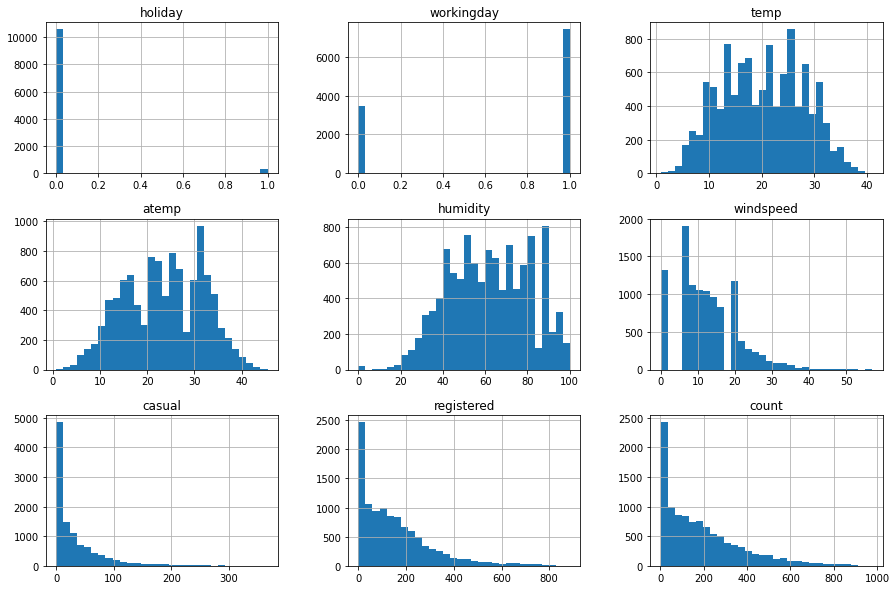

In [ ]:
# View histogram of all features again now with the hour feature
train.hist(bins=30, figsize=(15, 10))

## Step 5: Rerun the model with the same settings as before, just with more features

In [ ]:
save_path = 'bike-Models-date-time-predictClass'
predictor_new_features = TabularPredictor('count', problem_type='regression', 
                                          path=save_path, learner_kwargs={'ignored_columns':['casual' , 'registered']} ).fit(train, time_limit=600, presets='best_quality')

Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "bike-Models-date-time-predictClass/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 13
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11293.64 MB
	Train Data (Original)  Memory Usage: 1.59 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinim

[1000]	train_set's rmse: 29.1144	valid_set's rmse: 37.444
[2000]	train_set's rmse: 24.5939	valid_set's rmse: 37.3866


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 29.1513	valid_set's rmse: 41.7151
[2000]	train_set's rmse: 24.7195	valid_set's rmse: 41.2177
[3000]	train_set's rmse: 21.8718	valid_set's rmse: 41.0832
[4000]	train_set's rmse: 19.7381	valid_set's rmse: 41.0397


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 29.6587	valid_set's rmse: 35.368


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 28.8509	valid_set's rmse: 41.9087


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 29.2035	valid_set's rmse: 39.9955


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 29.5214	valid_set's rmse: 38.8051
[2000]	train_set's rmse: 25.0027	valid_set's rmse: 38.3551


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 29.2048	valid_set's rmse: 38.956
[2000]	train_set's rmse: 24.7004	valid_set's rmse: 38.7517
[3000]	train_set's rmse: 21.7576	valid_set's rmse: 38.6892


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 28.8345	valid_set's rmse: 43.6763


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	-39.718	 = Validation score   (root_mean_squared_error)
	31.56s	 = Training   runtime
	1.89s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 362.09s of the 562.1s of remaining time.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 20.4819	valid_set's rmse: 36.9382


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 20.642	valid_set's rmse: 40.533
[2000]	train_set's rmse: 14.2078	valid_set's rmse: 40.26


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 20.5969	valid_set's rmse: 36.9997


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 20.3751	valid_set's rmse: 40.4555


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 20.4588	valid_set's rmse: 39.8934


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 20.6592	valid_set's rmse: 37.6586


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 20.2382	valid_set's rmse: 43.1456


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	-39.3568	 = Validation score   (root_mean_squared_error)
	20.07s	 = Training   runtime
	0.88s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 339.11s of the 539.13s of remaining time.
	-41.8084	 = Validation score   (root_mean_squared_error)
	13.29s	 = Training   runtime
	0.47s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 323.54s of the 523.56s of remaining time.
	Time limit exceeded... Skipping CatBoost_BAG_L1.
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 286.7s of the 486.71s of remaining time.
	-41.1851	 = Validation score   (root_mean_squared_error

In [ ]:
predictor_new_features = TabularPredictor.load('./bike-Models-date-time-predictClass')  # how to load previously-trained predictor from file
predictor_new_features.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L2  -37.988516       4.207814  241.945342                0.000656           0.538869            2       True         10
1      WeightedEnsemble_L3  -38.086125       8.821500  472.011739                0.000638           0.305379            3       True         17
2     ExtraTreesMSE_BAG_L2  -38.416738       8.150619  347.873746                0.545762           7.672433            2       True         15
3          CatBoost_BAG_L2  -38.582345       7.678370  378.583902                0.073512          38.382589            2       True         14
4          LightGBM_BAG_L2  -38.628887       7.791484  374.375236                0.186627          34.173923            2       True         12
5   RandomForestMSE_BAG_L2  -38.994778       8.163848  376.835938         

{'leaderboard':                      model   score_val  ...  can_infer  fit_order
 0      WeightedEnsemble_L2  -37.988516  ...       True         10
 1      WeightedEnsemble_L3  -38.086125  ...       True         17
 2     ExtraTreesMSE_BAG_L2  -38.416738  ...       True         15
 3          CatBoost_BAG_L2  -38.582345  ...       True         14
 4          LightGBM_BAG_L2  -38.628887  ...       True         12
 5   RandomForestMSE_BAG_L2  -38.994778  ...       True         13
 6        LightGBMXT_BAG_L2  -39.088493  ...       True         11
 7          LightGBM_BAG_L1  -39.356826  ...       True          4
 8   NeuralNetFastAI_BAG_L2  -39.660971  ...       True         16
 9        LightGBMXT_BAG_L1  -39.717992  ...       True          3
 10  NeuralNetFastAI_BAG_L1  -40.949494  ...       True          7
 11    ExtraTreesMSE_BAG_L1  -41.185121  ...       True          6
 12  RandomForestMSE_BAG_L1  -41.808439  ...       True          5
 13          XGBoost_BAG_L1  -43.703402  ...   

In [ ]:
# Remember to set all negative values to zero
predictions_new = predictor_new_features.predict(test)
print(predictions_new.head())
print(predictions_new[predictions_new < 0])
print(len(predictions_new[predictions_new < 0]))
predictions_new[predictions_new < 0] = 0
print(len(predictions_new[predictions_new < 0]))

0    13.769157
1     4.974021
2     1.461930
3     2.637503
4     2.371739
Name: count, dtype: float32
27     -0.889317
52     -2.928915
53     -2.282344
75     -3.369709
76     -2.374342
96     -1.687773
97     -1.584855
192    -1.414405
439    -1.445751
440    -1.071522
556    -0.011098
724    -0.119467
867    -2.457613
868    -3.089838
915    -0.374865
916    -1.303040
939    -0.350886
3014   -3.759709
3084   -0.421971
4109   -2.817142
4112   -5.845719
4325   -5.624488
4326   -6.408031
4328   -7.463823
6283   -1.745358
Name: count, dtype: float32
25
0


In [ ]:
# Same submitting predictions
submission_new_features = pd.read_csv('./sampleSubmission.csv', parse_dates=['datetime'])
submission_new_features["count"] = predictions_new
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100% 188k/188k [00:02<00:00, 90.7kB/s]
Successfully submitted to Bike Sharing Demand

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features.csv  2021-12-26 09:51:53  new features          complete  0.48168      0.48168       
submission.csv               2021-12-26 09:22:09  first raw submission  complete  1.39407      1.39407       
submission.csv               2021-12-24 07:45:44  first raw submission  complete  1.39748      1.39748       


In [ ]:
save_path = 'bike-Models-independent-date-time-predictClass'
predictor_independent_features = TabularPredictor('count', problem_type='regression', 
                                          path=save_path, learner_kwargs={'ignored_columns':['casual', 'datetime' , 'registered']} ).fit(train, time_limit=600, presets='best_quality')

Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "bike-Models-independent-date-time-predictClass/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 13
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'datetime', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11249.2 MB
	Train Data (Original)  Memory Usage: 1.5 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitti

[1000]	train_set's rmse: 29.9214	valid_set's rmse: 37.9528
[2000]	train_set's rmse: 25.3247	valid_set's rmse: 37.7707


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 29.5276	valid_set's rmse: 41.8083
[2000]	train_set's rmse: 25.1539	valid_set's rmse: 41.4651
[3000]	train_set's rmse: 22.3692	valid_set's rmse: 41.339


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 29.875	valid_set's rmse: 36.0158


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 29.4633	valid_set's rmse: 42.5193


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 29.7326	valid_set's rmse: 40.0973


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 29.6363	valid_set's rmse: 42.1779


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 29.8896	valid_set's rmse: 38.9671
[2000]	train_set's rmse: 25.4792	valid_set's rmse: 38.7685


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 29.7259	valid_set's rmse: 38.7573


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	-39.9211	 = Validation score   (root_mean_squared_error)
	30.74s	 = Training   runtime
	1.65s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 363.78s of the 563.8s of remaining time.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argum

[1000]	train_set's rmse: 20.741	valid_set's rmse: 36.7353


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 20.5858	valid_set's rmse: 40.8092


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 20.7831	valid_set's rmse: 40.1068


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 20.7425	valid_set's rmse: 37.5717


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a f

In [ ]:
predictor_independent_features = TabularPredictor.load('./bike-Models-independent-date-time-predictClass')  # how to load previously-trained predictor from file
predictor_independent_features.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L2  -38.329149       4.514402  243.526106                0.000648           0.420050            2       True         10
1      WeightedEnsemble_L3  -38.344466       9.565711  474.794088                0.000664           0.309178            3       True         17
2     ExtraTreesMSE_BAG_L2  -38.609262       8.244282  302.176109                0.572876           7.266946            2       True         15
3          CatBoost_BAG_L2  -38.843059       7.825600  354.195723                0.154194          59.286559            2       True         14
4          LightGBM_BAG_L2  -39.009257       7.828121  302.474573                0.156715           7.565409            2       True         12
5   RandomForestMSE_BAG_L2  -39.103720       8.232015  326.225291         

{'leaderboard':                      model   score_val  ...  can_infer  fit_order
 0      WeightedEnsemble_L2  -38.329149  ...       True         10
 1      WeightedEnsemble_L3  -38.344466  ...       True         17
 2     ExtraTreesMSE_BAG_L2  -38.609262  ...       True         15
 3          CatBoost_BAG_L2  -38.843059  ...       True         14
 4          LightGBM_BAG_L2  -39.009257  ...       True         12
 5   RandomForestMSE_BAG_L2  -39.103720  ...       True         13
 6        LightGBMXT_BAG_L2  -39.503934  ...       True         11
 7   NeuralNetFastAI_BAG_L2  -39.605067  ...       True         16
 8          LightGBM_BAG_L1  -39.907034  ...       True          4
 9        LightGBMXT_BAG_L1  -39.921141  ...       True          3
 10    ExtraTreesMSE_BAG_L1  -41.485346  ...       True          6
 11  NeuralNetFastAI_BAG_L1  -41.910654  ...       True          7
 12  RandomForestMSE_BAG_L1  -41.977468  ...       True          5
 13          XGBoost_BAG_L1  -43.749400  ...   

In [ ]:
# Remember to set all negative values to zero
predictions_independent = predictor_independent_features.predict(test)
print(predictions_independent.head())
print(predictions_independent[predictions_independent < 0])
print(len(predictions_independent[predictions_independent < 0]))
predictions_independent[predictions_independent < 0] = 0
print(len(predictions_independent[predictions_independent < 0]))

0    13.721030
1     4.746763
2     1.662209
3     2.931067
4     2.695409
Name: count, dtype: float32
52     -1.965939
53     -2.598184
75     -2.425157
76     -1.982363
96     -0.780175
97     -0.692139
192    -0.898183
439    -0.198847
556    -0.398775
557    -0.215835
558    -0.653328
581    -0.036772
723    -0.137002
724    -0.530939
867    -2.385391
868    -3.782177
916    -1.082697
3014   -4.183029
3179   -0.220892
3395   -0.577769
4109   -3.827591
4112   -6.421842
4325   -6.719227
4326   -6.822623
4327   -0.522034
4328   -7.908324
Name: count, dtype: float32
26
0


In [ ]:
print("AutoGluon infers problem type is: ", predictor_independent_features.problem_type)
print("AutoGluon identified the following types of features:")
print(predictor_independent_features.feature_metadata)

AutoGluon infers problem type is:  regression
AutoGluon identified the following types of features:
('category', [])             : 3 | ['season', 'weather', 'time']
('float', [])                : 3 | ['temp', 'atemp', 'windspeed']
('int', [])                  : 1 | ['humidity']
('int', ['bool'])            : 2 | ['holiday', 'workingday']
('int', ['datetime_as_int']) : 1 | ['date']


In [ ]:
# Same submitting predictions
submission_independent_features = pd.read_csv('./sampleSubmission.csv', parse_dates=['datetime'])
submission_independent_features["count"] = predictions_independent
submission_independent_features.to_csv("submission_independent_features.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_independent_features.csv -m "new features"

100% 188k/188k [00:01<00:00, 131kB/s]
Successfully submitted to Bike Sharing Demand

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                             date                 description           status    publicScore  privateScore  
-----------------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_independent_features.csv  2021-12-27 05:26:29  new features          complete  0.47959      0.47959       
submission_independent_features.csv  2021-12-26 10:13:42  new features          complete  0.47959      0.47959       
submission_new_features.csv          2021-12-26 09:51:53  new features          complete  0.48168      0.48168       


#### New Score of `0.47959`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [ ]:
train["workingday"] = train["workingday"].astype("category")
train["holiday"] = train["holiday"].astype("category")
test["workingday"] = test["workingday"].astype("category")
test["holiday"] = test["holiday"].astype("category")

In [ ]:
train.corr()

,temp,atemp,humidity,windspeed,casual,registered,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948
count,0.394454,0.389784,-0.317371,0.101369,0.690414,0.970948,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b23da8150>,
      dtype=object)

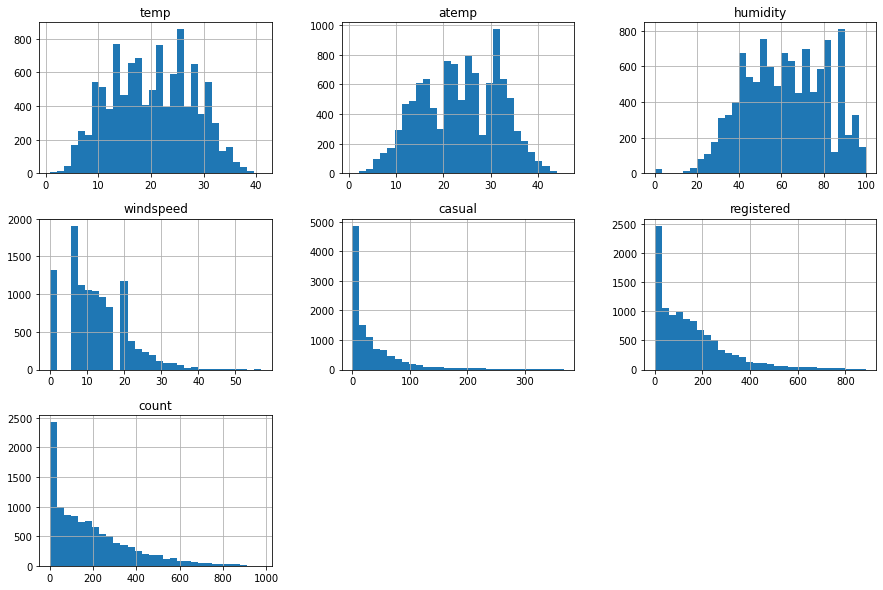

In [ ]:
# View histogram of all features again now with the hour feature
train.hist(bins=30, figsize=(15, 10))

In [ ]:
num_trials = 5  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = 'auto'  # to tune hyperparameters using Bayesian optimization routine with a local scheduler

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}
excluded_model_types = ['KNN', 'NN']

save_path = 'bike-Models-all-category-predictClass'
predictor_category_features = TabularPredictor('count', problem_type='regression', 
                                          path=save_path, learner_kwargs={'ignored_columns':['casual', 'datetime' , 'registered']} ).fit(
                                          train, time_limit=600, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
                                          excluded_model_types=excluded_model_types, presets='best_quality')

Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "bike-Models-all-category-predictClass/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 13
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'datetime', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    10966.54 MB
	Train Data (Original)  Memory Usage: 1.35 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting Cate

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 29.6045	valid_set's rmse: 37.7798


	Ran out of time, early stopping on iteration 1587. Best iteration is:
	[1577]	train_set's rmse: 26.7148	valid_set's rmse: 37.5429
	Time limit exceeded
Fitted model: LightGBMXT_BAG_L1/T0 ...
	-37.5429	 = Validation score   (root_mean_squared_error)
	3.8s	 = Training   runtime
	0.21s	 = Validation runtime
Hyperparameter tuning model: LightGBM_BAG_L1 ...


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	Ran out of time, early stopping on iteration 656. Best iteration is:
	[656]	train_set's rmse: 33.3206	valid_set's rmse: 42.3605
	Time limit exceeded
Fitted model: LightGBM_BAG_L1/T0 ...
	-38.1139	 = Validation score   (root_mean_squared_error)
	1.36s	 = Training   runtime
	0.05s	 = Validation runtime
Fitted mode

  0%|          | 0/5 [00:00<?, ?it/s]

	Time limit exceeded
Fitted model: CatBoost_BAG_L1/T0 ...
	-82.5272	 = Validation score   (root_mean_squared_error)
	2.78s	 = Training   runtime
	0.17s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesMSE_BAG_L1 ...
Fitted model: ExtraTreesMSE_BAG_L1/T0 ...
	-41.4853	 = Validation score   (root_mean_squared_error)
	6.71s	 = Training   runtime
	0.54s	 = Validation runtime
Hyperparameter tuning model: NeuralNetFastAI_BAG_L1 ...
	Ran out of time, stopping training early. (Stopping on epoch 5)
Fitted model: NeuralNetFastAI_BAG_L1/T0 ...
	-145.3358	 = Validation score   (root_mean_squared_error)
	3.38s	 = Training   runtime
	0.05s	 = Validation runtime
Hyperparameter tuning model: XGBoost_BAG_L1 ...


  0%|          | 0/5 [00:00<?, ?it/s]

	Time limit exceeded
Fitted model: XGBoost_BAG_L1/T0 ...
	-41.3599	 = Validation score   (root_mean_squared_error)
	3.88s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 4.49s of the 540.99s of remaining time.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	-37.4132	 = Validation score   (root_mean_squared_error)
	3.92s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L1/T0 ... Training model for up to 336.45s of the 536.32s of remaining time.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of

[1000]	train_set's rmse: 29.5276	valid_set's rmse: 41.8083
[2000]	train_set's rmse: 25.1539	valid_set's rmse: 41.4651
[3000]	train_set's rmse: 22.3692	valid_set's rmse: 41.339


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 29.875	valid_set's rmse: 36.0158


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 29.4633	valid_set's rmse: 42.5193


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 29.7326	valid_set's rmse: 40.0973


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 29.6363	valid_set's rmse: 42.1779


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 29.8896	valid_set's rmse: 38.9671
[2000]	train_set's rmse: 25.4792	valid_set's rmse: 38.7685


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 29.7259	valid_set's rmse: 38.7573


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	-39.9023	 = Validation score   (root_mean_squared_error)
	37.87s	 = Training   runtime
	1.86s	 = Validation runtime
Fitting model: LightGBM_BAG_L1/T0 ... Training model for up to 297.96s of the 497.83s of remaining time.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' a

[1000]	train_set's rmse: 20.741	valid_set's rmse: 36.7353


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 20.5858	valid_set's rmse: 40.8092


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 20.7831	valid_set's rmse: 40.1068


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 20.7425	valid_set's rmse: 37.5717


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a f

[1000]	train_set's rmse: 20.741	valid_set's rmse: 36.7353


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 20.5858	valid_set's rmse: 40.8092


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 20.7831	valid_set's rmse: 40.1068


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 20.7425	valid_set's rmse: 37.5717


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a f

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	Ran out of time, early stopping on iteration 272. Best iteration is:
	[124]	train_set's rmse: 36.519	valid_set's rmse: 41.3393
	Time limit exceeded
Fitted model: LightGBMXT_BAG_L2/T0 ...
	-41.3393	 = Validation score   (root_mean_squared_error)
	1.6s	 = Training   runtime
	0.03s	 = Validation runtime
Hyperparameter tuning model: LightGBM_BAG_L2 ...


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	Time limit exceeded
Fitted model: LightGBM_BAG_L2/T0 ...
	-39.7814	 = Validation score   (root_mean_squared_error)
	1.07s	 = Training   runtime
	0.02s	 = Validation runtime
Hyperparameter tuning model: RandomForestMSE_BAG_L2 ...
Fitted model: RandomForestMSE_BAG_L2/T0 ...
	-39.262	 = Validation score   (root_mean_squared_error)
	30.24s	 = Training   runtime
	1.15s	 = Validation runtime
Hyperparameter tuning model: CatBoost_BAG_L2 ...


  0%|          | 0/5 [00:00<?, ?it/s]

	Time limit exceeded
Fitted model: CatBoost_BAG_L2/T0 ...
	-39.823	 = Validation score   (root_mean_squared_error)
	1.75s	 = Training   runtime
	0.02s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesMSE_BAG_L2 ...
Fitted model: ExtraTreesMSE_BAG_L2/T0 ...
	-38.8205	 = Validation score   (root_mean_squared_error)
	8.61s	 = Training   runtime
	0.58s	 = Validation runtime
Hyperparameter tuning model: NeuralNetFastAI_BAG_L2 ...
	Ran out of time, stopping training early. (Stopping on epoch 2)
Fitted model: NeuralNetFastAI_BAG_L2/T0 ...
	-45.6402	 = Validation score   (root_mean_squared_error)
	1.82s	 = Training   runtime
	0.05s	 = Validation runtime
Hyperparameter tuning model: XGBoost_BAG_L2 ...


  0%|          | 0/5 [00:00<?, ?it/s]

	Time limit exceeded
Fitted model: XGBoost_BAG_L2/T0 ...
	-39.446	 = Validation score   (root_mean_squared_error)
	1.25s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 2.32s of the 142.85s of remaining time.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	Ran out of time, early stopping on iteration 256. Best iteration is:
	[118]	train_set's rmse: 25.0559	valid_set's rmse: 40.0328
	-40.0328	 = Validation score   (root_mean_squared_error)
	2.02s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L2/T0 ... Training model for up to 140.58s of the 140.51s of remaining time.
/usr/local/lib/python3.7/dis

In [ ]:
predictor_category_features = TabularPredictor.load('bike-Models-all-category-predictClass')
predictor_category_features.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                        model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        LightGBMLarge_BAG_L1 -37.413172       0.130720    3.921357                0.130720           3.921357            1       True          9
1         WeightedEnsemble_L3 -38.354510       7.145235  425.522444                0.000836           0.331050            3       True         19
2         WeightedEnsemble_L2 -38.501170       3.835718   72.052474                0.001297           0.618256            2       True         10
3          CatBoost_BAG_L2/T0 -38.627875       5.874132  329.207324                0.094300          43.458205            2       True         14
4     ExtraTreesMSE_BAG_L2/T0 -38.820537       6.359997  294.354189                0.580164           8.605070            2       True         15
5          LightGBM_BAG_L2/T0 -38.960980       5.958716  296.7

{'leaderboard':                         model  score_val  ...  can_infer  fit_order
 0        LightGBMLarge_BAG_L1 -37.413172  ...       True          9
 1         WeightedEnsemble_L3 -38.354510  ...       True         19
 2         WeightedEnsemble_L2 -38.501170  ...       True         10
 3          CatBoost_BAG_L2/T0 -38.627875  ...       True         14
 4     ExtraTreesMSE_BAG_L2/T0 -38.820537  ...       True         15
 5          LightGBM_BAG_L2/T0 -38.960980  ...       True         12
 6   RandomForestMSE_BAG_L2/T0 -39.262049  ...       True         13
 7           XGBoost_BAG_L2/T0 -39.445994  ...       True         17
 8        LightGBMXT_BAG_L2/T0 -39.533922  ...       True         11
 9        LightGBMXT_BAG_L1/T0 -39.902278  ...       True          1
 10         LightGBM_BAG_L1/T0 -39.907034  ...       True          2
 11       LightGBMLarge_BAG_L2 -40.032759  ...       True         18
 12  NeuralNetFastAI_BAG_L2/T0 -40.071753  ...       True         16
 13         LightGB

In [ ]:
predictions_category_features = predictor_category_features.predict(test)

In [ ]:
# Remember to set all negative values to zero
print(predictions_category_features.head())
print(predictions_category_features[predictions_category_features < 0])
print(len(predictions_category_features[predictions_category_features < 0]))
predictions_category_features[predictions_category_features < 0] = 0
print(len(predictions_category_features[predictions_category_features < 0]))

0    11.305120
1     5.503338
2     4.174058
3     4.982790
4     4.804758
Name: count, dtype: float32
Series([], Name: count, dtype: float32)
0
0


In [ ]:
# Same submitting predictions
submission_category_features = pd.read_csv('./sampleSubmission.csv', parse_dates=['datetime'])
submission_category_features["count"] = predictions_category_features
submission_category_features.to_csv("submission_category_features.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_category_features.csv -m "prediction_all_category_features"

100% 188k/188k [00:00<00:00, 460kB/s]
Successfully submitted to Bike Sharing Demand

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                             date                 description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [ ]:
predictor_new_features = predictor_independent_features
predictor_new_hpo = predictor_category_features

#### New Score of ` 0.45586 `

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

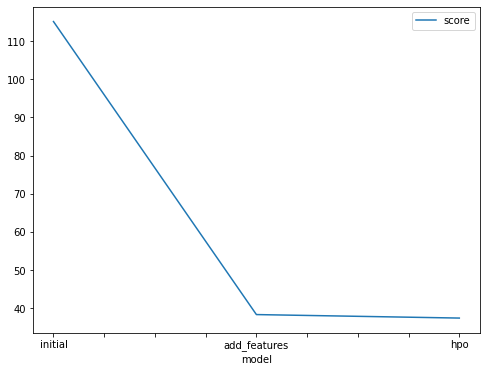

In [ ]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": [ "initial", "add_features", "hpo"],
        "score": [-predictor.leaderboard( silent=True)['score_val'][0],
                  -predictor_new_features.leaderboard( silent=True)['score_val'][0],
                  -predictor_new_hpo.leaderboard( silent=True)['score_val'][0]]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

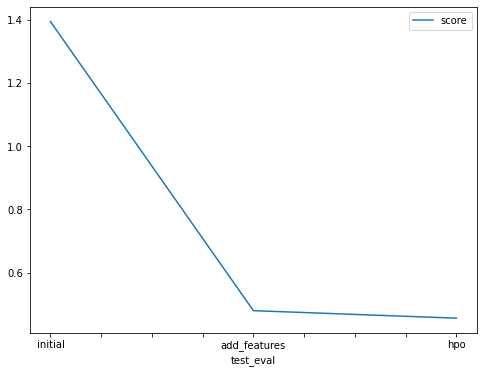

In [ ]:
# Take the 3 kaggle scores and creating a line plot to show improvement

fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.39407,
                  0.47959,
                  0.45586]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')


### Hyperparameter table

In [ ]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ["problem_type='regression'", 
             "Added two distinct features 'date' and 'time' to train data",
             "hyperparameter_tune_kwargs={'num_trials':5, 'scheduler' : 'local',  'searcher':'auto}"],
    "hpo2": ["learner_kwargs={'ignored_columns':['casual' , 'registered']}", 
             "learner_kwargs={'ignored_columns':['casual', 'datetime' , 'registered']}",
             "Changing the format of 'workingday' and 'holiday' to category"],
    "hpo3": ["time_limit=600", 
             "Changing the format of 'season' and 'weather' to category",
             "excluded_model_types = ['KNN', 'NN']"],
    "score": [1.39407, 0.47959, 0.45586]
})

,model,hpo1,hpo2,hpo3,score
0,initial,problem_type='regression',"learner_kwargs={'ignored_columns':['casual' , 'registered']}",time_limit=600,1.39407
1,add_features,Added two distinct features 'date' and 'time' to train data,"learner_kwargs={'ignored_columns':['casual', 'datetime' , 'registered']}",Changing the format of 'season' and 'weather' to category,0.47959
2,hpo,"hyperparameter_tune_kwargs={'num_trials':5, 'scheduler' : 'local', 'searcher':'auto}",Changing the format of 'workingday' and 'holiday' to category,"excluded_model_types = ['KNN', 'NN']",0.45586
